## import the dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

## The CNN model

In [2]:
def CNN_model(input_data_shape, output_data_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_data_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        # Dense(64, activation='relu'),
        Dense(output_data_shape, activation='linear')
    ])
    return model

## function for processing images

In [ ]:
def standardize_images(data):
    processed_data = np.zeros_like(data)  
    for i in range(data.shape[0]):
        image = data[i]    
        # Step 1: Threshold - set pixels below 33% of the maximum to 0
        threshold_value = 0.33 * image.max()
        image = np.where(image < threshold_value,0, image)        
        # Step 2: Normalize - scale pixel values to the range [0, 1]
        if image.max() > 0:
            normalized_image = image / image.max()
        else:
            normalized_image = image  # If max is 0, keep as is (all zeros)
        processed_data[i] = normalized_image
    return processed_data

def process_images(data):
    if len(data.shape)==2:
        processed_images = np.expand_dims(data, axis = 0)
        standardized_images = standardize_images(processed_images)
    elif len(data.shape)==3:
        standardized_images = standardize_images(data)
    else:
        print('incorrect image format')

    standardized_images=np.expand_dims(standardized_images, axis=-1)

    return standardized_images

## load the training data

In [3]:
data = tifffile.imread('datasets/training_5000.tif')
target = np.load('datasets/training_5000.npy')


## process training images 

In [4]:
processed_data = process_images(data)
processed_data.shape

## determine the input and output data shape

In [8]:
input_data_shape=processed_data.shape[1:]
output_data_shape=target.shape[1]

## split the input data into training and testing sets

In [10]:
x_train, x_test, y_train, y_test=train_test_split(processed_data,target,test_size=0.1)
del processed_data, data
del target

## to make the model

In [12]:
model = CNN_model(input_data_shape, output_data_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 107584)            0

# to train the model

In [13]:
model.compile(optimizer='adam', loss='mse',metrics=['acc'])

# checkpoint=ModelCheckpoint(filepath='CNN gaws v3 checkpoints/checkpoint',save_best_only=True,
#                             save_weights_only=True, monitor='val_acc',verbose=0)
# earlystopping=EarlyStopping(monitor='val_acc',patience=3)

In [14]:
history=model.fit(x=x_train,y=y_train, epochs=20, validation_data=(x_test,y_test), verbose=1)
                  #callbacks=[checkpoint,earlystopping],verbose=2)

Epoch 1/20
155/155 [==============================] - 62s 389ms/step - loss: 0.0121 - acc: 0.7251 - val_loss: 7.7778e-04 - val_acc: 0.8836
Epoch 2/20
155/155 [==============================] - 60s 386ms/step - loss: 5.5236e-04 - acc: 0.8826 - val_loss: 4.4561e-04 - val_acc: 0.8745
Epoch 3/20
155/155 [==============================] - 62s 401ms/step - loss: 3.2904e-04 - acc: 0.8941 - val_loss: 2.8915e-04 - val_acc: 0.8818
Epoch 4/20
155/155 [==============================] - 59s 383ms/step - loss: 2.4496e-04 - acc: 0.9053 - val_loss: 2.0944e-04 - val_acc: 0.9255
Epoch 5/20
155/155 [==============================] - 61s 395ms/step - loss: 1.8398e-04 - acc: 0.9158 - val_loss: 2.0335e-04 - val_acc: 0.8909
Epoch 6/20
155/155 [==============================] - 59s 383ms/step - loss: 1.3882e-04 - acc: 0.9265 - val_loss: 1.6597e-04 - val_acc: 0.9145
Epoch 7/20
155/155 [==============================] - 59s 383ms/step - loss: 1.3321e-04 - acc: 0.9343 - val_loss: 1.5190e-04 - val_acc: 0.9182
Epo

In [15]:
df = pd.DataFrame(history.history)
df.to_csv('datasets/training parameters.csv')

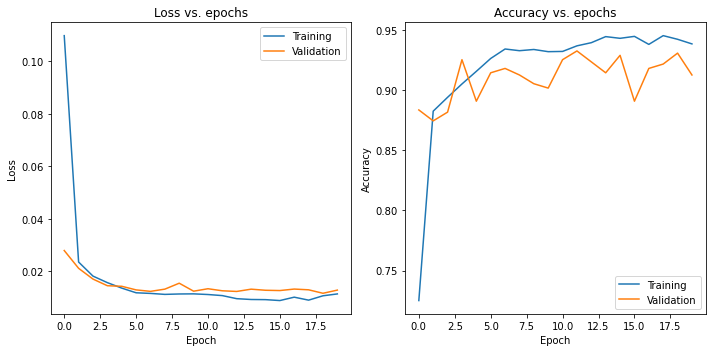

In [18]:
fig,ax=plt.subplots(1,2, figsize=(10, 5))

ax[0].plot(np.sqrt(history.history['loss']),label='Training')
ax[0].plot(np.sqrt(history.history['val_loss']),label= 'Validation')
ax[0].set_title('Loss vs. epochs')
ax[0].set(ylabel='Loss',xlabel='Epoch')
ax[0].legend( loc='best')


ax[1].plot(history.history['acc'],label='Training')
ax[1].plot(history.history['val_acc'],label= 'Validation')
ax[1].set_title('Accuracy vs. epochs')
ax[1].set(ylabel='Accuracy',xlabel='Epoch')
ax[1].legend(loc='best')


fig.tight_layout()
plt.show() 

## save the trained model

In [17]:
model.save('saved_model/gaws_model_v1.keras')

# Model is already trained and we need only to load the weights

## load the pre trained model

In [12]:
model = tf.keras.models.load_model('saved_model/gaws_model_v1.keras')

## load the testing data

In [13]:
data_test = tifffile.imread('datasets/test_z4_z15_0.5.tif')
target_test = np.load('datasets/test_z4_z15_0.5.npy')

## process the testing images

In [ ]:
data_test = process_images(data_test)
data_test.shape

## use the trained model to predict aberrations

In [18]:
y_predict=model.predict(data_test)

1/1 [==============================] - 0s 437ms/step


<BarContainer object of 12 artists>

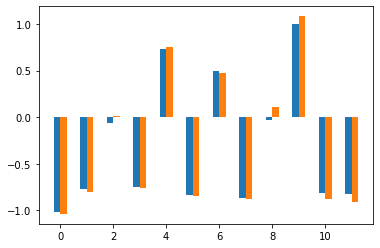

In [43]:
plt.bar(np.arange(len(y_predict[0]))-0.12,y_predict[0], label='estimated' , width = 0.24)
plt.bar(np.arange(len(target_test[0]))+0.12,target_test[0],label='applied', width = 0.24)



## determine RMSE

In [ ]:
def RMSE(target,predict):
    MSE = np.square(np.subtract(target,predict)).mean()
    RMSE = np.sqrt(MSE)
    return RMSE



In [ ]:
rmse_values = []
for i in range(data_test.shape[0]):
  rmse = RMSE(target_test[i], y_predict[i])
  rmse_values.append(rmse)

plt.figure()
plt.plot(rmse_values)
plt.ylim(0,1.5)